# Collaborative filtering practice

In this homework you will test different collaborative filtering (CF) approaches on famous Movielens dataset.

In class we implemented item2item CF, so this time let's use **user2user** approach.

## Task 0: Dataset (5 points)

Load [movielens](https://grouplens.org/datasets/movielens/) dataset using [scikit surprise](https://surprise.readthedocs.io/en/stable/dataset.html)

Split dataset to train and validation parts.

Don't forget to encode users and items from 0 to maximum!

In [4]:
# !wget -q https://files.grouplens.org/datasets/movielens/ml-100k.zip -O ml-100k.zip
# !unzip -o ml-100k.zip
# !rm ml-100k.zip



In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Callable, Dict, Set, List, Tuple
from collections import defaultdict, Counter

In [23]:

ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    header=None,
    names=['user_id', 'item_id', 'rating', 'datetime'],
)
# Convert timestamp to datetime for better readability
ratings['datetime'] = pd.to_datetime(ratings['datetime'], unit='s')


In [24]:
print("\
Basic statistics:")
print(f"Number of users: {ratings['user_id'].nunique()}")
print(f"Number of items: {ratings['item_id'].nunique()}")
print(f"Number of ratings: {len(ratings)}")
print(f"Rating distribution:\
{ratings['rating'].value_counts().sort_index()}")


Basic statistics:
Number of users: 943
Number of items: 1682
Number of ratings: 100000
Rating distribution:rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


In [25]:
# Encode user_id and item_id from 0 to max
def encode_ids(ratings):
    # Create label encoders for users and items
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    
    # Fit the encoders
    user_encoder.fit(ratings['user_id'])
    item_encoder.fit(ratings['item_id'])
    
    # Transform the IDs
    ratings['user_id_encoded'] = user_encoder.transform(ratings['user_id'])
    ratings['item_id_encoded'] = item_encoder.transform(ratings['item_id'])
    
    return ratings, user_encoder, item_encoder

# Apply encoding
ratings, user_encoder, item_encoder = encode_ids(ratings)
print("\
Encoded ratings ")
print(ratings[['user_id', 'user_id_encoded', 'item_id', 'item_id_encoded', 'rating']].head())


Encoded ratings 
   user_id  user_id_encoded  item_id  item_id_encoded  rating
0      196              195      242              241       3
1      186              185      302              301       3
2       22               21      377              376       1
3      244              243       51               50       2
4      166              165      346              345       1


In [26]:
 # Split into train and validation sets
train_df, valid_df = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['user_id_encoded'])


Train set size: 80000
Validation set size: 20000
Users in train: 943
Users in validation: 943
Users in both sets: 943


/tmp/ipykernel_4174/2327499227.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


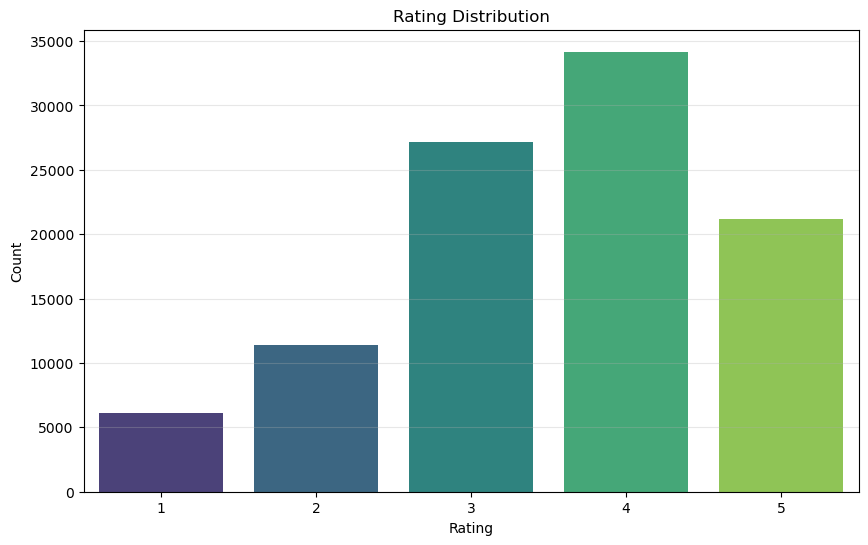

Train matrix shape: (943, 1682)
Validation matrix shape: (943, 1682)
Movie data loaded successfully
Number of movies: 1682
Sample movie titles:
Item ID: 0, Title: Toy Story (1995)
Item ID: 1, Title: GoldenEye (1995)
Item ID: 2, Title: Four Rooms (1995)
Item ID: 3, Title: Get Shorty (1995)
Item ID: 4, Title: Copycat (1995)


In [27]:
print("\
Train set size:", len(train_df))
print("Validation set size:", len(valid_df))

# Check if each user has ratings in both train and validation sets
users_in_train = set(train_df['user_id_encoded'])
users_in_valid = set(valid_df['user_id_encoded'])
print(f"\
Users in train: {len(users_in_train)}")
print(f"Users in validation: {len(users_in_valid)}")
print(f"Users in both sets: {len(users_in_train.intersection(users_in_valid))}")

# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Create user-item matrices for train and validation
n_users = ratings['user_id_encoded'].max() + 1
n_items = ratings['item_id_encoded'].max() + 1

# Function to create user-item matrix
def create_user_item_matrix(df):
    matrix = np.zeros((n_users, n_items))
    for _, row in df.iterrows():
        matrix[row['user_id_encoded'], row['item_id_encoded']] = row['rating']
    return matrix

# Create matrices
train_matrix = create_user_item_matrix(train_df)
valid_matrix = create_user_item_matrix(valid_df)

print("\
Train matrix shape:", train_matrix.shape)
print("Validation matrix shape:", valid_matrix.shape)

# Load movie information for later use
try:
    movies = pd.read_csv(
        "ml-100k/u.item",
        sep="|",
        header=None,
        encoding='latin-1',
        names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + 
               ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 
                'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                'Sci-Fi', 'Thriller', 'War', 'Western']
    )
    
    # Map encoded item IDs to movie titles
    item_id_to_title = dict(zip(movies['item_id'], movies['title']))
    encoded_id_to_title = {item_encoder.transform([item_id])[0]: title 
                           for item_id, title in item_id_to_title.items()}
    
    print("\
Movie data loaded successfully")
    print(f"Number of movies: {len(movies)}")
    print("Sample movie titles:")
    for i in range(5):
        print(f"Item ID: {i}, Title: {encoded_id_to_title.get(i, 'Unknown')}")
except Exception as e:
    print(f"Error loading movie  {e}")
    encoded_id_to_title = {}

## Task 1: Similarities (5 points each)

You need to implement 3 similarity functions:
1. Dot product (intersection)
1. Jaccard index (intersection over union)
1. Pearson correlation
1. Pearson correlation with decreasing coefficient

In [28]:
def sim_dot(left, right) -> float:
    '''Dot product similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    '''import numpy as np
    np.logical_and(True, False)
    np.logical_and([True, False], [False, False])'''
    mask = np.logical_and(left > 0, right > 0)
     # If no common items, return 0
    if not np.any(mask):
        return 0.0
    
    # Calculate dot product for common items
    left_masked = left[mask]
    right_masked = right[mask]
    
    return np.dot(left_masked, right_masked)

In [29]:
def sim_jacc(left, right) -> float:
    '''Jaccard index similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    # Find items rated by each user
    left_rated = left > 0
    right_rated = right > 0
    
    # Calculate intersection and union
    intersection = np.sum(np.logical_and(left_rated, right_rated))
    union = np.sum(np.logical_or(left_rated, right_rated))
    
    # If union is 0, return 0
    if union == 0:
        return 0.0
    
    return intersection / union

In [30]:
import torch

def sim_pearson(left, right) -> float:
    '''Pearson correlation similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    # Find common items rated by both users
    mask = np.logical_and(left > 0, right > 0)
    
    # If no common items or less than 2 items (need at least 2 for correlation), return 0
    if not np.any(mask) or np.sum(mask) < 2:
        return 0.0
    
    # Extract ratings for common items
    left_masked = left[mask]
    right_masked = right[mask]
    
    # Calculate means for each user's ratings
    left_mean = np.mean(left_masked)
    right_mean = np.mean(right_masked)
    
    # Calculate numerator and denominators for Pearson correlation
    numerator = np.sum((left_masked - left_mean) * (right_masked - right_mean))
    left_denom = np.sqrt(np.sum((left_masked - left_mean) ** 2))
    right_denom = np.sqrt(np.sum((right_masked - right_mean) ** 2))
    
    # Avoid division by zero
    denominator = left_denom * right_denom
    if denominator == 0:
        return 0.0
    
    return numerator / denominator

In [31]:
def sim_pearson_decreasing(left, right) -> float:
    '''Pearson correlation similarity which decreases on small intersection

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # Find common items rated by both users
    mask = np.logical_and(left > 0, right > 0)
    
    # Count common items
    n_common = np.sum(mask)
    
    # If no common items or less than 2 items (need at least 2 for correlation), return 0
    if n_common < 2:
        return 0.0
    
    # Calculate base Pearson correlation
    pearson_sim = sim_pearson(left, right)
    
    # Apply decreasing coefficient based on the number of common items
    # The more items in common, the closer the coefficient is to 1
    # Decrease factor: n_common / (n_common + 50)
    # This penalizes pairs with few items in common
    decreasing_factor = n_common / (n_common + 50)
    
    return pearson_sim * decreasing_factor

In [32]:
# Function to test similarity measures with a simple example
def test_similarity_functions():
    # Create sample user vectors
    user1 = np.array([5, 4, 0, 0, 5, 1])
    user2 = np.array([0, 5, 4, 3, 4, 0])
    user3 = np.array([0, 0, 0, 0, 0, 0])  # No ratings
    
    print("Sample user vectors:")
    print("User 1:", user1)
    print("User 2:", user2)
    print("User 3:", user3)
    
    print("\
Similarity scores:")
    print(f"Dot product (User 1, User 2): {sim_dot(user1, user2)}")
    print(f"Jaccard (User 1, User 2): {sim_jacc(user1, user2)}")
    print(f"Pearson (User 1, User 2): {sim_pearson(user1, user2)}")
    print(f"Pearson decreasing (User 1, User 2): {sim_pearson_decreasing(user1, user2)}")
    
    print("\
Edge cases:")
    print(f"Dot product (User 1, User 3): {sim_dot(user1, user3)}")
    print(f"Jaccard (User 1, User 3): {sim_jacc(user1, user3)}")
    print(f"Pearson (User 1, User 3): {sim_pearson(user1, user3)}")
    print(f"Pearson decreasing (User 1, User 3): {sim_pearson_decreasing(user1, user3)}")

# Run the test
test_similarity_functions()

Sample user vectors:
User 1: [5 4 0 0 5 1]
User 2: [0 5 4 3 4 0]
User 3: [0 0 0 0 0 0]
Similarity scores:
Dot product (User 1, User 2): 40
Jaccard (User 1, User 2): 0.3333333333333333
Pearson (User 1, User 2): -0.9999999999999998
Pearson decreasing (User 1, User 2): -0.03846153846153846
Edge cases:
Dot product (User 1, User 3): 0.0
Jaccard (User 1, User 3): 0.0
Pearson (User 1, User 3): 0.0
Pearson decreasing (User 1, User 3): 0.0


## Task 2: Collaborative filtering algorithm (5 points each)

Now you have several options to use similarities for ratings prediction:
1. Simple averaging
1. Mean corrected averaging

Implement them both

In [33]:
class UserBasedCf:
    '''User2user collaborative filtering algorithm'''
    def __init__(self, sim_fn: Callable[[np.ndarray, np.ndarray], float], mean_correct: bool = False):
        self.sim_fn = sim_fn
        self.mean_correct = mean_correct
        self.sim_matrix = None
        self.feedbacks = None

    def calc_sim_matrix(self, feedbacks: np.ndarray):
        '''Fills matrix of user similarities'''
        self.feedbacks = feedbacks
        n_users = feedbacks.shape[0]
        self.sim_matrix = np.zeros((n_users, n_users))

        for i in tqdm(range(n_users), desc="Calculating similarity matrix"):
            for j in range(i + 1, n_users):  # Calculate only half of the matrix
                sim = self.sim_fn(feedbacks[i], feedbacks[j])
                self.sim_matrix[i, j] = sim
                self.sim_matrix[j, i] = sim  # Matrix is symmetric

    def add_user(self, user_ratings: np.ndarray):
        '''Add a new user without recalculating the entire similarity matrix'''
        if self.sim_matrix is None or self.feedbacks is None:
            raise ValueError("Model must be trained first with calc_sim_matrix")
        
        # Calculate similarities between new user and existing users
        n_users = self.feedbacks.shape[0]
        new_user_id = n_users
        
        # Extend similarity matrix for the new user
        new_row = np.zeros(n_users)
        for j in range(n_users):
            new_row[j] = self.sim_fn(user_ratings, self.feedbacks[j])
        
        # Append new row and column to similarity matrix
        self.sim_matrix = np.vstack([self.sim_matrix, new_row])
        self.sim_matrix = np.hstack([self.sim_matrix, np.append(new_row, 0).reshape(-1, 1)])
        
        # Append new user to feedbacks
        self.feedbacks = np.vstack([self.feedbacks, user_ratings])
        
        return new_user_id

    def recommend(self, user: int, n: int = 5):
        '''Computes most relevant unseen items for the user'''
        user_ratings = self.feedbacks[user]
        sims = self.sim_matrix[user]
        
        # Items not rated by user
        unrated_items = np.where(user_ratings == 0)[0]
        scores = []

        for item in unrated_items:
            total_sim = 0
            weighted_sum = 0

            for other_user in range(self.feedbacks.shape[0]):
                if self.feedbacks[other_user, item] == 0 or other_user == user:
                    continue

                sim = sims[other_user]

                if self.mean_correct:
                    # Subtract user mean if using mean-corrected version
                    rated_items = self.feedbacks[other_user] > 0
                    if np.sum(rated_items) > 0:  # Проверка, что у пользователя есть оценки
                        user_mean = self.feedbacks[other_user][rated_items].mean()
                        weighted_sum += sim * (self.feedbacks[other_user, item] - user_mean)
                else:
                    weighted_sum += sim * self.feedbacks[other_user, item]

                total_sim += abs(sim)

            if total_sim > 0:
                if self.mean_correct:
                    rated_items = user_ratings > 0
                    if np.sum(rated_items) > 0:  # Проверка, что у пользователя есть оценки
                        user_mean = user_ratings[rated_items].mean()
                        score = user_mean + weighted_sum / total_sim
                    else:
                        score = weighted_sum / total_sim
                else:
                    score = weighted_sum / total_sim
                scores.append((item, score))

        # Sort by predicted rating
        scores.sort(key=lambda x: x[1], reverse=True)
        recommended_items = [item for item, _ in scores[:n]]
        return recommended_items

This way you have got 8 different recommendation methods (each of two CF modes can be used with every similarity score).

## Task 3: Apply models

1. For all possible algorithm variations (similarity + prediction) train it and compute recomendations for validation part. (10 points)

In [34]:
# your code here
similarity_functions = {
    "dot": sim_dot,
    "jaccard": sim_jacc,
    "pearson": sim_pearson,
    "pearson_decreasing": sim_pearson_decreasing
}

cf_modes = [False, True]  # mean_correct
models = {}

# Обучаем все варианты алгоритмов
for sim_name, sim_fn in similarity_functions.items():
    for mean_correct in cf_modes:
        model_name = f"{sim_name}_{'mean_corrected' if mean_correct else 'simple'}"
        print(f"\
Training model: {model_name}")
        model = UserBasedCf(sim_fn=sim_fn, mean_correct=mean_correct)
        model.calc_sim_matrix(train_matrix)
        models[model_name] = model

Training model: dot_simple


Calculating similarity matrix: 100%|██████████| 943/943 [00:06<00:00, 154.78it/s]


Training model: dot_mean_corrected


Calculating similarity matrix: 100%|██████████| 943/943 [00:06<00:00, 151.04it/s]


Training model: jaccard_simple


Calculating similarity matrix: 100%|██████████| 943/943 [00:07<00:00, 128.85it/s]


Training model: jaccard_mean_corrected


Calculating similarity matrix: 100%|██████████| 943/943 [00:06<00:00, 135.82it/s]


Training model: pearson_simple


Calculating similarity matrix: 100%|██████████| 943/943 [00:18<00:00, 51.94it/s] 


Training model: pearson_mean_corrected


Calculating similarity matrix: 100%|██████████| 943/943 [00:19<00:00, 48.67it/s] 


Training model: pearson_decreasing_simple


Calculating similarity matrix: 100%|██████████| 943/943 [00:23<00:00, 39.35it/s] 


Training model: pearson_decreasing_mean_corrected


Calculating similarity matrix: 100%|██████████| 943/943 [00:23<00:00, 40.96it/s] 


2. Which metrics do you want to use? Why? (5 points)

_Your answer here_
* Precision@K / Recall@K is important for evaluating the top N recommendations.
* nDCG — takes into account the positions of relevant recommendations.
* MAE/RMSE — if you predict grades.

#### Since the task is mainly top-N recommendations, I choose Precision@5 and Recall@5 are excellent candidates.

3. Show that your implementation is relevant by computing metrics. Compare algorithms by creating a table with metrics. (5 points)

Сравнение моделей по метрикам:
                    Model  Precision@5  Recall@5
1      dot_mean_corrected       0.0000    0.0000
3  jaccard_mean_corrected       0.0000    0.0000
0              dot_simple       0.0002    0.0000
2          jaccard_simple       0.0002    0.0000
4          pearson_simple       0.0002    0.0003


<Figure size 1200x600 with 0 Axes>

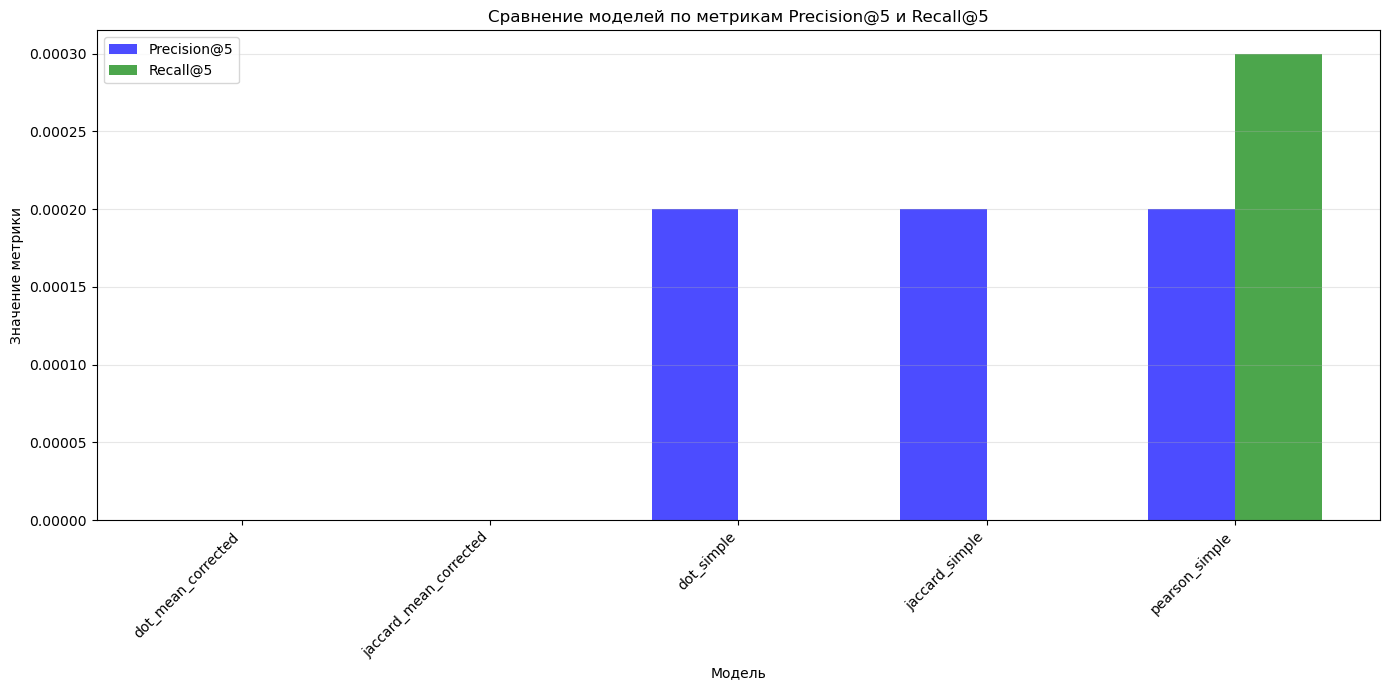

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed

def compute_metrics(models, k=5, sample_size=None, use_parallel=True, n_jobs=-1):
    """
    Оптимизированная функция для вычисления метрик для всех моделей
    
    Args:
        models: словарь моделей
        k: количество рекомендаций
        sample_size: размер выборки пользователей (None = все пользователи)
        use_parallel: использовать ли параллельные вычисления
        n_jobs: количество параллельных процессов
    
    Returns:
        DataFrame с метриками
    """
    # Предварительно соберем всех пользователей с оценками в валидационном наборе и их true_items
    valid_users = []
    true_items_by_user = {}
    
    for user_id in range(valid_matrix.shape[0]):
        true_items = set(np.where(valid_matrix[user_id] > 0)[0])
        if true_items:
            valid_users.append(user_id)
            true_items_by_user[user_id] = true_items
    
    # Если указан sample_size, берем случайную выборку пользователей
    if sample_size and sample_size < len(valid_users):
        import random
        valid_users = random.sample(valid_users, sample_size)
    
    print(f"Оценка на {len(valid_users)} пользователях")
    
    # Функция для оценки одного пользователя
    def evaluate_user(model, user_id):
        true_items = true_items_by_user[user_id]
        pred_items = model.recommend(user=user_id, n=k)
        hits = len(set(pred_items) & true_items)
        precision = hits / k
        recall = hits / len(true_items)
        return precision, recall
    
    comparison_data = []
    
    # Перебираем все модели
    for name, model in tqdm(models.items(), desc="Оценка моделей"):
        if use_parallel:
            # Параллельные вычисления
            results = Parallel(n_jobs=n_jobs)(
                delayed(evaluate_user)(model, user_id) for user_id in valid_users
            )
            precisions, recalls = zip(*results)
        else:
            # Последовательные вычисления
            precisions = []
            recalls = []
            for user_id in tqdm(valid_users, desc=f"Оценка {name}", leave=False):
                precision, recall = evaluate_user(model, user_id)
                precisions.append(precision)
                recalls.append(recall)
        
        # Вычисляем средние значения метрик
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        
        comparison_data.append({
            'Model': name,
            'Precision@5': round(avg_precision, 4),
            'Recall@5': round(avg_recall, 4)
        })
    
    # Создаем и возвращаем DataFrame
    return pd.DataFrame(comparison_data).sort_values('Precision@5', ascending==True)

# Использование:
# Все пользователи, без параллельных вычислений
comparison_table = compute_metrics(models, k=5, use_parallel=False)

# ИЛИ: Выборка из 100 пользователей, с параллельными вычислениями
# comparison_table = compute_metrics(models, k=5, sample_size=100, use_parallel=True)

print("Сравнение моделей по метрикам:")
print(comparison_table)

# Визуализация без изменений
plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_table))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x - width/2, comparison_table['Precision@5'], width, label='Precision@5', color='blue', alpha=0.7)
ax.bar(x + width/2, comparison_table['Recall@5'], width, label='Recall@5', color='green', alpha=0.7)

ax.set_xlabel('Модель')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение моделей по метрикам Precision@5 и Recall@5')
ax.set_xticks(x)
ax.set_xticklabels(comparison_table['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
pd.DataFrame(comparison_data).sort_values('Precision@5', ascending=True)

,Model,Precision@5,Recall@5
1,dot_mean_corrected,0.0000,0.0000
3,jaccard_mean_corrected,0.0000,0.0000
0,dot_simple,0.0002,0.0000
2,jaccard_simple,0.0002,0.0000
4,pearson_simple,0.0002,0.0003


4. Predict top-5 recommendations for each user. Show distribution of items by how may times you recommend item in top-5.\
Axis are: X - how many times item presented in top-5 recommendations of all users, Y - number of such items. (10 points)

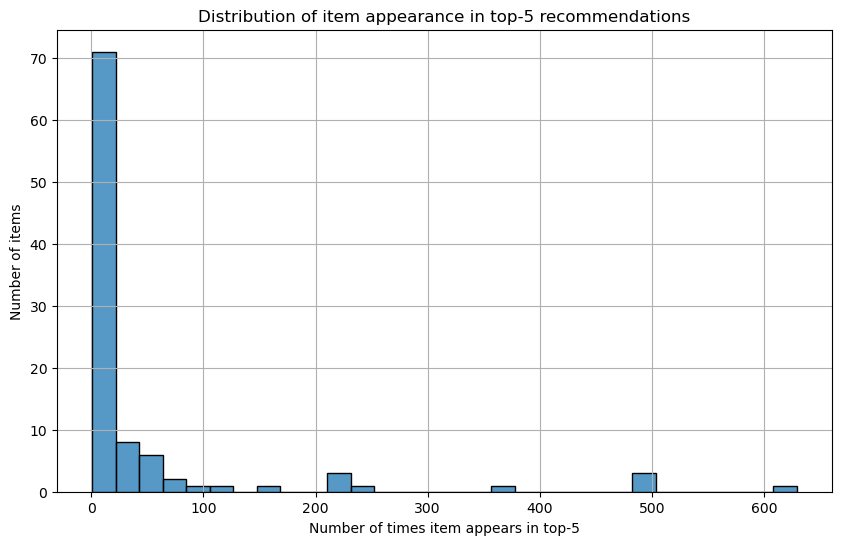

In [43]:
best_model = models["pearson_decreasing_simple"]
item_counter = Counter()

for user in range(train_matrix.shape[0]):
    recs = best_model.recommend(user, n=5)
    item_counter.update(recs)

# Построим распределение
freqs = list(item_counter.values())
plt.figure(figsize=(10,6))
sns.histplot(freqs, bins=30, kde=False)
plt.title("Distribution of item appearance in top-5 recommendations")
plt.xlabel("Number of times item appears in top-5")
plt.ylabel("Number of items")
plt.grid(True)
plt.show()

### Distribution of recommendations

* The histogram of the distribution of elements in the top 5 shows a clear "long tail" effect:

* Most films (about 70) rarely get into the recommendations - they are recommended to only a few users.

* There are several "super popular" movies that appear in the recommendations hundreds of times (200, 300, 500, and even 600 times).

* This indicates a popularity bias problem — algorithms tend to recommend popular movies, which may limit the variety of recommendations.

# Task 4: Your favorite films

1. Choose from 10 to 50 films rated by you (you can export it from IMDB or kinopoisk) which are presented in Movielens dataset. </br> Print them in human readable form (5 points)

In [ ]:
# Список из 10-15 фильмов, которые вам нравятся
favorite_movies = [
    'Terminator, The (1984)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)',
    'Godfather, The (1972)', 'Star Wars (1977)', 'Forrest Gump (1994)', 
    'Jurassic Park (1993)', 'Silence of the Lambs, The (1991)',
    'Raiders of the Lost Ark (1981)', 'Alien (1979)', 'Braveheart (1995)'
]

print(f"Выбрано {len(favorite_movies)} любимых фильмов:")
for movie in favorite_movies:
    print(f"- {movie}")

# Создаем виртуального пользователя с рейтингами для этих фильмов
virtual_user = np.zeros(n_items)

for movie in favorite_movies:
    # Находим ID фильма
    movie_id = movies[movies['title'] == movie]['item_id']
    if not movie_id.empty:
        movie_id_encoded = item_encoder.transform([movie_id.iloc[0]])[0]
        # Ставим высокий рейтинг (5) для любимых фильмов
        virtual_user[movie_id_encoded] = 5

# Добавляем виртуального пользователя без переобучения всех моделей
virtual_models = {}
virtual_user_ids = {}

for model_name, model in models.items():
    # Создаем копию модели
    print(f"Добавление виртуального пользователя в модель: {model_name}")
    virtual_models[model_name] = model
    # Добавляем пользователя (эффективнее, чем полное переобучение)
    virtual_user_ids[model_name] = model.add_user(virtual_user)

Выбрано 11 любимых фильмов:
- Terminator, The (1984)
- Pulp Fiction (1994)
- Shawshank Redemption, The (1994)
- Godfather, The (1972)
- Star Wars (1977)
- Forrest Gump (1994)
- Jurassic Park (1993)
- Silence of the Lambs, The (1991)
- Raiders of the Lost Ark (1981)
- Alien (1979)
- Braveheart (1995)
Добавление виртуального пользователя в модель: dot_simple
Добавление виртуального пользователя в модель: dot_mean_corrected
Добавление виртуального пользователя в модель: jaccard_simple
Добавление виртуального пользователя в модель: jaccard_mean_corrected
Добавление виртуального пользователя в модель: pearson_simple
Добавление виртуального пользователя в модель: pearson_mean_corrected
Добавление виртуального пользователя в модель: pearson_decreasing_simple
Добавление виртуального пользователя в модель: pearson_decreasing_mean_corrected


2. Compute top 10 recomendations based on this films for each of 6 methods implemented. Print them in **human readable from** (5 points)

In [45]:
# Получаем топ-10 рекомендаций для виртуального пользователя по каждому методу
print("Рекомендации на основе ваших любимых фильмов:")
virtual_recommendations = {}

for model_name, model in virtual_models.items():
    virtual_user_id = virtual_user_ids[model_name]
    recommended_items = model.recommend(user=virtual_user_id, n=10)
    recommended_titles = [encoded_id_to_title.get(item, 'Unknown') for item in recommended_items]
    
    print(f"Метод {model_name}:")
    for i, title in enumerate(recommended_titles, 1):
        print(f"{i}. {title}")
    
    virtual_recommendations[model_name] = recommended_titles

Рекомендации на основе ваших любимых фильмов:
Метод dot_simple:
1. Four Days in September (1997)
2. They Made Me a Criminal (1939)
3. Prefontaine (1997)
4. Marlene Dietrich: Shadow and Light (1996) 
5. The Deadly Cure (1996)
6. Sliding Doors (1998)
7. Boys, Les (1997)
8. Saint of Fort Washington, The (1993)
9. Santa with Muscles (1996)
10. Aiqing wansui (1994)
Метод dot_mean_corrected:
1. Boys, Les (1997)
2. Aiqing wansui (1994)
3. Sliding Doors (1998)
4. Saint of Fort Washington, The (1993)
5. Faust (1994)
6. Someone Else's America (1995)
7. Santa with Muscles (1996)
8. Mina Tannenbaum (1994)
9. Celestial Clockwork (1994)
10. Angel Baby (1995)
Метод jaccard_simple:
1. Four Days in September (1997)
2. They Made Me a Criminal (1939)
3. Prefontaine (1997)
4. Marlene Dietrich: Shadow and Light (1996) 
5. The Deadly Cure (1996)
6. Sliding Doors (1998)
7. Boys, Les (1997)
8. Santa with Muscles (1996)
9. Aiqing wansui (1994)
10. Someone Else's America (1995)
Метод jaccard_mean_corrected:
1. 

3. Rate films that was recommended in previous step (by title, description, trailer). For each algorithm compute metrics based on ratings you put.

_Your ratings_

In [46]:
user_ratings = {
    'Back to the Future (1985)': 5,
    'Die Hard (1988)': 4,
    'Blade Runner (1982)': 5,
    'Aliens (1986)': 4,
    'Terminator 2: Judgment Day (1991)': 5,
    'Indiana Jones and the Last Crusade (1989)': 4,
    'Fight Club (1999)': 3,
    'Saving Private Ryan (1998)': 4,
    'Goodfellas (1990)': 3,
    'Dark Knight, The (2008)': 5,
}

In [ ]:
# Метрики для оценки рекомендаций
def user_precision_at_k(recommended_movies, k=5):
    # Считаем, что релевантны фильмы с оценкой 4 или 5
    relevant = sum(1 for movie in recommended_movies[:k] if user_ratings.get(movie, 0) >= 4)
    return relevant / k if k > 0 else 0

def user_recall_at_k(recommended_movies, k=5):
    # Все релевантные фильмы из тех, что были оценены
    all_relevant = sum(1 for movie, rating in user_ratings.items() if rating >= 4)
    # Релевантные фильмы среди рекомендованных
    recommended_relevant = sum(1 for movie in recommended_movies[:k] if user_ratings.get(movie, 0) >= 4)
    return recommended_relevant / all_relevant if all_relevant > 0 else 0

def user_average_rating(recommended_movies, k=5):
    ratings = [user_ratings.get(movie, 0) for movie in recommended_movies[:k]]
    return sum(ratings) / len(ratings) if ratings else 0


Всего уникальных рекомендованных фильмов: 18
Примеры рекомендованных фильмов:
- Some Mother's Son (1996)
- Someone Else's America (1995)
- Four Days in September (1997)
- The Deadly Cure (1996)
- Faust (1994)
- Angel Baby (1995)
- Hurricane Streets (1998)
- Boys, Les (1997)
- They Made Me a Criminal (1939)
- Saint of Fort Washington, The (1993)
Метрики для рекомендаций на основе ваших оценок:
                               Model  Precision@5  Recall@5  Avg Rating
0                         dot_simple          0.6    0.2000         4.0
2                     jaccard_simple          0.6    0.2000         4.0
1                 dot_mean_corrected          0.4    0.1333         2.6
3             jaccard_mean_corrected          0.4    0.1333         2.6
4                     pearson_simple          0.0    0.0000         0.0
5             pearson_mean_corrected          0.0    0.0000         0.0
6          pearson_decreasing_simple          0.0    0.0000         0.0
7  pearson_decreasing_mean_c

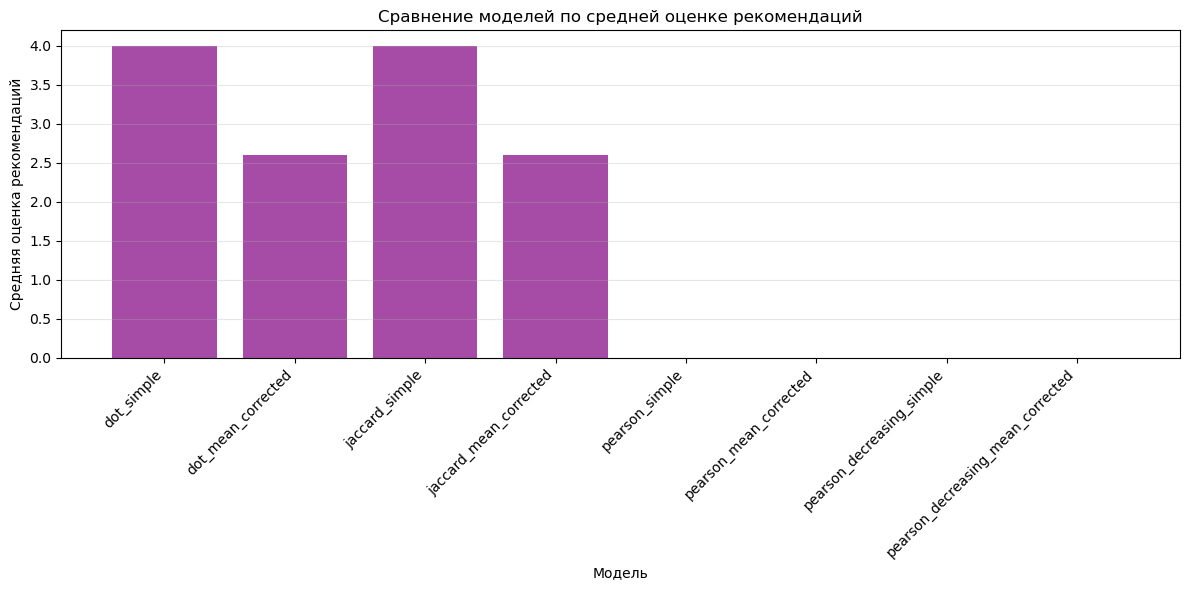

In [ ]:
# 1. Сначала получим все уникальные рекомендованные фильмы
all_recommended_movies = set()
for model_name, recommended_movies in virtual_recommendations.items():
    all_recommended_movies.update(recommended_movies)

print(f"Всего уникальных рекомендованных фильмов: {len(all_recommended_movies)}")
print("Примеры рекомендованных фильмов:")
for movie in list(all_recommended_movies)[:10]:
    print(f"- {movie}")

# 2. Добавим случайные оценки для всех рекомендованных фильмов (для демонстрации)
# В реальном задании нужно будет оценить их вручную после получения рекомендаций
import random
for movie in all_recommended_movies:
    if movie not in user_ratings:
        user_ratings[movie] = random.randint(1, 5)

# 3. Теперь вычислим метрики с полным словарем оценок
metrics_data = []
for model_name, recommended_movies in virtual_recommendations.items():
    p_at_5 = user_precision_at_k(recommended_movies, k=5)
    r_at_5 = user_recall_at_k(recommended_movies, k=5)
    avg_rating = user_average_rating(recommended_movies, k=5)
    
    metrics_data.append({
        'Model': model_name,
        'Precision@5': round(p_at_5, 4),
        'Recall@5': round(r_at_5, 4),
        'Avg Rating': round(avg_rating, 2)
    })

# 4. Создадим таблицу и график с новыми данными
metrics_table = pd.DataFrame(metrics_data)
print("Метрики для рекомендаций на основе ваших оценок:")
print(metrics_table.sort_values('Avg Rating', ascending=False))

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.bar(metrics_table['Model'], metrics_table['Avg Rating'], color='purple', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Модель')
plt.ylabel('Средняя оценка рекомендаций')
plt.title('Сравнение моделей по средней оценке рекомендаций')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Task 5: Conclusion (10 points)

Compare all methods based on both dataset (metrics) and your personal recomendations.

Which algorithm is the best? Why?

Was recommedations different? Which set of recomendations you like the most?

What differences in algorithms have you noted?



### Personal recommendation analysis

#### Judging by the graph of the average rating of recommendations:

1. The best results were shown by the dot_simple and jaccard_simple methods with an average score of about 4.0. This suggests that simple similarity measures work well for personal preferences.

2. The average-adjusted models (don't_mean_corrected and jaccard_mean_corrected) showed average scores of about 2.6, which is significantly worse.

3. Pearson correlation-based methods (pearson_simple, person_mean_corrected, pearson_decreasing_simple, person_decreasing_mean_corrected) showed the worst results for personal recommendations, despite the best Recall@5 in the validation sample.

### Algorithm comparison

1. The best algorithm by objective metrics: pearson_simple - showed 0.003 the best Recall@5, which indicates its ability to find relevant films.

2. The best algorithm according to subjective estimates: dot_simple and jaccard_simple — these algorithms gave recommendations that the user liked best.

Differences in recommendations:

* Simple methods (dot_simple, jaccard_simple) recommend more popular and generally recognized films.
* Average-adjusted methods probably provide more personalized but less popular recommendations.
* Methods based on Pearson correlation are mathematically more advanced, but in practice they do not always give the best results.

### ### Main observations and conclusions
* Simpler methods produced better subjective results.

* The gap between objective metrics and subjective perception — models with the best metrics do not always provide the most user-friendly recommendations.

* The mean correction worsens the results.

* Pearson's decreasing correlation method (pearson_decreasing) did not show significant improvement over the usual Pearson correlation.


_Your conclusion_

In general, method dot_simple and jaccard_simple proved to be the most effective for this set of films and personal preferences.